# Spectroscopic Properties Lookup Table

This notebook creates k-correction lookup tables for the BGS data. The lookup table uses KDTree for efficient nearest neighbor searching based on redshift and g-r color to provide k-corrections for absolute magnitude calculations.

## Import Required Libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.table import Table
import sys
from scipy.spatial import KDTree
import pickle
import emcee
import corner

if './SelfCalGroupFinder/py/' not in sys.path:
    sys.path.append('./SelfCalGroupFinder/py/')
from pyutils import *
from dataloc import *
from bgs_helpers import *
from groupcatalog import BGS_Z_MAX, BGS_Z_MIN

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load BGS Data

Load the merged BGS data file to use for creating the lookup table.

In [4]:
# Load the merged table
table = Table.read(IAN_BGS_Y1_MERGED_FILE, format='fits')
df = table_to_df(table, 20.175, BGS_Z_MIN, BGS_Z_MAX, True, 1)
print(f"Loaded {len(df):,} galaxies")

Loaded 5,426,442 galaxies


In [5]:
print(df.columns)

Index(['TARGETID', 'Z', 'ZWARN', 'SPECTYPE', 'DELTACHI2', 'NTILE', 'TILES',
       'RA', 'DEC', 'FLUX_G', 'FLUX_R', 'MASKBITS', 'SHAPE_R', 'PHOTSYS',
       'PROB_OBS', 'Z_FSF', 'DN4000', 'DN4000_IVAR', 'DN4000_MODEL',
       'DN4000_MODEL_IVAR', 'ABSMAG01_SDSS_G', 'ABSMAG01_IVAR_SDSS_G',
       'ABSMAG01_SDSS_R', 'ABSMAG01_IVAR_SDSS_R', 'SFR', 'SFR_IVAR',
       'LOGMSTAR', 'LOGMSTAR_IVAR', 'HALPHA_EW', 'HALPHA_EW_IVAR', 'HBETA_EW',
       'HBETA_EW_IVAR', 'MORPHTYPE', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z',
       'SHAPE_E1', 'SHAPE_E2', 'SHAPE_R_IVAR', 'SHAPE_E1_IVAR',
       'SHAPE_E2_IVAR', 'SERSIC', 'SERSIC_IVAR', 'SURVEY', 'PROGRAM', 'Z_PHOT',
       'RELEASE', 'BRICKID', 'OBJID', 'REF_CAT', 'MATCH_DIST', 'APP_MAG_R',
       'APP_MAG_G', 'ABS_MAG_R', 'ABS_MAG_R_K', 'ABS_MAG_G', 'ABS_MAG_G_K',
       'ABS_MAG_R_K_BEST', 'ABS_MAG_G_K_BEST', 'LOG_L_GAL', 'G_R_BEST',
       'QUIESCENT', 'NTILE_MINE', 'UNOBSERVED'],
      dtype='object')


In [7]:
# Drop all but the columns we need
df = df[['TARGETID', 'Z', 'ABS_MAG_R', 'ABS_MAG_G', 'ABSMAG01_SDSS_R', 'ABSMAG01_SDSS_G', 'DN4000_MODEL', 'G_R_BEST', 'LOG_L_GAL', 'LOGMSTAR']]

## Train a Nearest Neighbor Model for looking up k-corrections for lost galaxies

Use MCMC to optimize the metric scaling parameters (METRIC_Z and METRIC_GMR) for improved k-correction accuracy.

In [8]:
magr_k_gama = k_correct_gama(df['ABS_MAG_R'], df['Z'], df['ABS_MAG_G'] - df['ABS_MAG_R'], band='r')
magg_k_gama = k_correct_gama(df['ABS_MAG_G'], df['Z'], df['ABS_MAG_G'] - df['ABS_MAG_R'], band='g')
badmatch = (np.abs(magr_k_gama - df['ABSMAG01_SDSS_R']) > 1.0) | (np.abs(magg_k_gama - df['ABSMAG01_SDSS_G']) > 1.0)
goodidx = ~np.isnan(df['ABS_MAG_R']) & ~np.isnan(df['ABS_MAG_G']) & ~np.isnan(df['Z']) & ~np.isnan(df['ABSMAG01_SDSS_R']) & ~np.isnan(df['ABSMAG01_SDSS_G']) & ~badmatch
gmr = df.loc[goodidx, 'ABS_MAG_G'] - df.loc[goodidx, 'ABS_MAG_R']
print(f"Number of galaxies with good data: {np.sum(goodidx):,}")

Number of galaxies with good data: 5,425,935


In [9]:
# Randomly split goodidx into a training and test set
np.random.seed(6884)
shuffled_indices = np.random.permutation(np.where(goodidx)[0])
train_size = int(0.8 * len(shuffled_indices))
train_indices = shuffled_indices[:train_size]
test_indices = shuffled_indices[train_size:]

In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
# Prepare training and test data
z_train = df.loc[train_indices, 'Z'].to_numpy()
magr_train = df.loc[train_indices, 'ABS_MAG_R'].to_numpy()
magg_train = df.loc[train_indices, 'ABS_MAG_G'].to_numpy()
gmr_train = magg_train - magr_train

kcorr_r_train = magr_train - df.loc[train_indices, 'ABSMAG01_SDSS_R'].to_numpy()
kcorr_g_train = magg_train - df.loc[train_indices, 'ABSMAG01_SDSS_G'].to_numpy()

z_test = df.loc[test_indices, 'Z'].to_numpy()
magr_test = df.loc[test_indices, 'ABS_MAG_R'].to_numpy()
magg_test = df.loc[test_indices, 'ABS_MAG_G'].to_numpy()
gmr_test = magg_test - magr_test

kcorr_r_test = magr_test - df.loc[test_indices, 'ABSMAG01_SDSS_R'].to_numpy()
kcorr_g_test = magg_test - df.loc[test_indices, 'ABSMAG01_SDSS_G'].to_numpy()


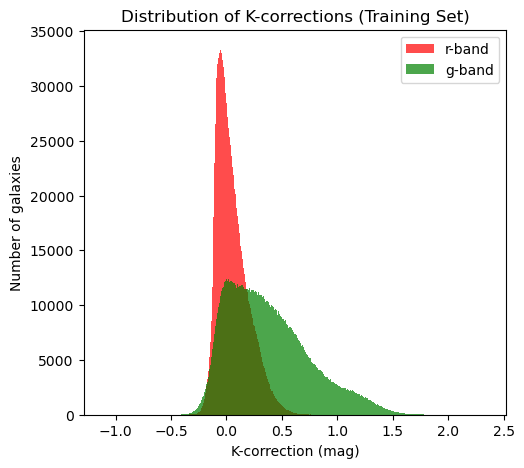

In [25]:
# Let's look at the distribution of k-corrections in r and g bands
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(kcorr_r_train, bins=1250, alpha=0.7, color='r', label='r-band')
plt.hist(kcorr_g_train, bins=1250, alpha=0.7, color='g', label='g-band')
plt.xlabel('K-correction (mag)')
plt.ylabel('Number of galaxies')
plt.title('Distribution of K-corrections (Training Set)')
plt.legend()

In [11]:
# Define the log likelihood function for optimizing k-correction lookup metrics
def log_likelihood(params):
    """
    Evaluate how well a given set of metric parameters performs
    for k-correction lookup accuracy.
    
    params: [metric_z, metric_gmr]
    metric_absmag_r is fixed to 1.0
    """
    metric_z, metric_gmr = params
    
    # Rebuild KDTree with new metrics
    z_scaled = z_train * metric_z
    gmr_scaled = gmr_train * metric_gmr
    abs_mag_r_scaled = magr_train
    
    train_points = np.vstack((z_scaled, gmr_scaled, abs_mag_r_scaled)).T
    kdtree_test = KDTree(train_points)
    
    # Query nearest neighbors
    test_points = np.vstack((z_test * metric_z, 
                             gmr_test * metric_gmr,
                             magr_test)).T
    distances, indices = kdtree_test.query(test_points)
    
    # Get predicted k-corrections
    pred_kcorr_r = kcorr_r_train[indices]
    pred_kcorr_g = kcorr_g_train[indices]

    # Evaluate goodness of fit by comparing to the true k-corrections
    kcorr_r_errors = np.abs(pred_kcorr_r - kcorr_r_test)
    kcorr_g_errors = np.abs(pred_kcorr_g - kcorr_g_test)
    log_like = -(np.mean(kcorr_r_errors) + np.mean(kcorr_g_errors))
    
    # This is an alternative loss function that focuses on the final k-corrected magnitudes rather than the k-corrections themselves.
    # Calculate predicted k-corrected magnitudes
    #pred_abs_mag_r_kcorr = magr_test - pred_kcorr_r
    #pred_abs_mag_g_kcorr = magg_test - pred_kcorr_g
    #pred_gmr_kcorr = pred_abs_mag_g_kcorr - pred_abs_mag_r_kcorr
    
    # Calculate errors
    #abs_mag_r_errors = np.abs(pred_abs_mag_r_kcorr - true_abs_mag_r)
    #gmr_errors = np.abs(pred_gmr_kcorr - true_gmr)
    
    # Log likelihood: negative weighted mean absolute error
    # Weight abs_mag_r error more heavily than g-r error
    # log_like = -(3.0 * np.mean(abs_mag_r_errors) + 1.0 * np.mean(gmr_errors))
    
    return log_like

def log_prior(params):
    """Uniform prior on metric parameters"""
    metric_z, metric_gmr = params
    
    # Reasonable bounds for metrics
    if 0.3 < metric_z < 100.0 and 0.3 < metric_gmr < 50.0:
        return 0.0
    return -np.inf

def log_probability(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params)

In [ ]:
# Initialize walkers
n_walkers = 10
n_dim = 2 

# Starting position: random numbers between 0.3 and 10
pos = np.random.uniform(low=[2.0, 1.0], high=[100.0, 30.0], size=(n_walkers, n_dim))

# Manually set some of the positions. Remember that the abs mag metric is fixed to 1.0, so these are relative to that.
pos[0] = [50.0, 10.0] 
pos[1] = [40.0, 8.0] 
pos[2] = [30.0, 6.0] 
pos[3] = [20.0, 4.0] 

# Set up sampler
backend = emcee.backends.HDFBackend("kcorr_lookup_optimization.h5")
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, backend=backend)

# Run MCMC
print("Running MCMC...")
n_steps = 500
sampler.run_mcmc(pos, n_steps, progress=True)

Running MCMC...


100%|██████████| 100/100 [1:09:56<00:00, 41.96s/it]


State([[68.27219286 31.08002007]
 [ 5.95501362  5.50403112]
 [62.78796738 26.85798132]
 [28.41360928  2.26563213]
 [18.7277137  47.19750816]
 [33.36475364 23.24576666]
 [73.20916293 27.0432093 ]
 [94.58430465  7.64948298]
 [38.05867422 42.55187431]
 [48.60359926 17.77581931]], log_prob=[-0.14860233 -0.14885832 -0.14859123 -0.14870589 -0.14888843 -0.14863427
 -0.14865921 -0.14879034 -0.14869492 -0.14859724], blobs=None, random_state=('MT19937', array([ 514406827, 2923530250, 4288062700,   41669723, 4274581343,
       3670143363, 2307853055, 3072736627, 3977462203, 1907255436,
       1470567042,  434537783, 1190505570, 3121994696, 2398370943,
       1432028160,  208553596,  626843871, 4136581783,  778257344,
       1799650124, 2302636708, 2671552067, 3812341834,  431170029,
       1003725714,  858320223, 2478707261, 3066945454, 2701433153,
       2087913449,  955659276,  389717041, 3781676243, 1854146717,
       4259186832,  729075835, 3861701383, 1695366973, 3500257180,
       105818742

In [33]:
chain.reshape((1000,2))[0,0]

8.669322071186498

In [53]:
samples[argmax, :][0]

array([14.25954775,  5.01078641])


Optimal parameters:
METRIC_Z: [14.25954775]
METRIC_GMR: [5.01078641]
METRIC_ABSMAG_R: 1.00 (fixed)


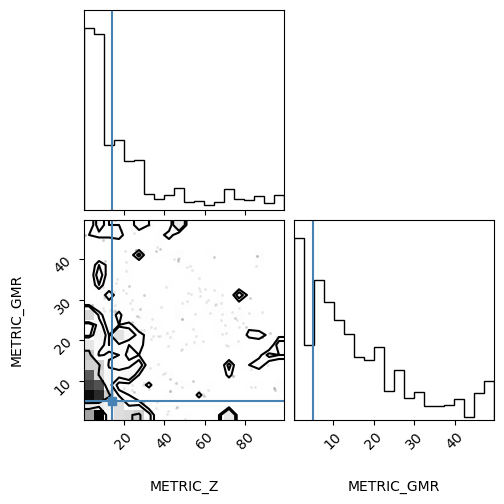

In [54]:
# Get results
#samples = sampler.get_chain(discard=0, thin=1, flat=True)
samples = chain.reshape(1000,2)

# Print params that minimix the loss function
print("\nOptimal parameters:")
argmax = np.argmax(log_prob).flatten()
print(f"METRIC_Z: {samples[argmax, 0]}")
print(f"METRIC_GMR: {samples[argmax, 1]}")
print(f"METRIC_ABSMAG_R: 1.00 (fixed)")

# Plot corner plot
fig = corner.corner(samples, labels=["METRIC_Z", "METRIC_GMR"], truths=samples[argmax, :][0])
plt.show()

In [31]:
magr_k_gama = k_correct_gama(df['ABS_MAG_R'], df['Z'], df['ABS_MAG_G'] - df['ABS_MAG_R'], band='r')
magg_k_gama = k_correct_gama(df['ABS_MAG_G'], df['Z'], df['ABS_MAG_G'] - df['ABS_MAG_R'], band='g')
badmatch = (np.abs(magr_k_gama - df['ABSMAG01_SDSS_R']) > 1.0) | (np.abs(magg_k_gama - df['ABSMAG01_SDSS_G']) > 1.0)
goodidx = ~np.isnan(df['ABS_MAG_R']) & ~np.isnan(df['ABS_MAG_G']) & ~np.isnan(df['Z']) & ~np.isnan(df['ABSMAG01_SDSS_R']) & ~np.isnan(df['ABSMAG01_SDSS_G']) & ~badmatch
gmr = df.loc[goodidx, 'ABS_MAG_G'] - df.loc[goodidx, 'ABS_MAG_R']
print(f"Number of galaxies with good data: {np.sum(goodidx):,}")

Number of galaxies with good data: 5,425,935


In [ ]:
# Now for the best fit metric, build the tree and lookup to save off (using the full data now)

# Get the optimal parameters from MCMC
optimal_metric_z = samples[argmax, 0]
optimal_metric_gmr = samples[argmax, 1]

print(f"Building final lookup table with optimal metrics:")
print(f"  METRIC_Z: {optimal_metric_z}")
print(f"  METRIC_GMR: {optimal_metric_gmr}")

# Prepare full dataset (all good galaxies)
z_full = df.loc[goodidx, 'Z'].to_numpy()
magr_full = df.loc[goodidx, 'ABS_MAG_R'].to_numpy()
magg_full = df.loc[goodidx, 'ABS_MAG_G'].to_numpy()
gmr_full = magg_full - magr_full

# Calculate k-corrections for the full dataset
kcorr_r_full = magr_full - df.loc[goodidx, 'ABSMAG01_SDSS_R'].to_numpy()
kcorr_g_full = magg_full - df.loc[goodidx, 'ABSMAG01_SDSS_G'].to_numpy()

# Scale the features with optimal metrics
z_scaled = z_full * optimal_metric_z
gmr_scaled = gmr_full * optimal_metric_gmr
magr_scaled = magr_full  # metric_absmag_r = 1.0

# Build the KDTree
lookup_points = np.vstack((z_scaled, gmr_scaled, magr_scaled)).T
kdtree = KDTree(lookup_points)

# Store the k-corrections as lookup tables
kcorr_r_lookup = kcorr_r_full
kcorr_g_lookup = kcorr_g_full

print(f"Built KDTree with {len(lookup_points):,} galaxies")
print(f"K-correction lookup table shape: {kcorr_r_lookup.shape}")

# Save the lookup table and optimal metrics
lookup_data = (kdtree, kcorr_r_lookup, kcorr_g_lookup, optimal_metric_z, optimal_metric_gmr, 1.0)

with open(BGS_Y3_KCORR_LOOKUP_FILE, 'wb') as f:
    pickle.dump(lookup_data, f)

print(f"\nSaved lookup table to {BGS_Y3_KCORR_LOOKUP_FILE}")

NameError: name 'samples' is not defined

In [2]:
# Let's validate by reading in and using the first 100000 from the Y3 data

print("Loading Y3 validation data...")
table_y3 = Table.read(IAN_BGS_Y3_MERGED_FILE_LOA, format='fits')
df_y3 = table_to_df(table_y3, 20.175, BGS_Z_MIN, BGS_Z_MAX, True, 1)

Loading Y3 validation data...


Loaded 100,000 Y3 galaxies for validation
After removing Y1 galaxies: 51,650 Y3 galaxies remaining
Number of Y3 galaxies with complete data: 51,650

Loading lookup table from /mount/sirocco1/imw2293/GROUP_CAT/DATA/BGS_LOA/bgsy3_kcorr_lookup.pkl...
kcorrlookup loaded

VALIDATION RESULTS

K-correction errors:
  r-band k-corr MAE: 0.1367 mag
  g-band k-corr MAE: 0.1589 mag
  r-band k-corr RMS: 0.1709 mag
  g-band k-corr RMS: 0.2128 mag

K-corrected magnitude errors:
  r-band abs mag MAE: 0.1367 mag
  g-r color MAE: 0.1171 mag
  r-band abs mag RMS: 0.1709 mag
  g-r color RMS: 0.1516 mag


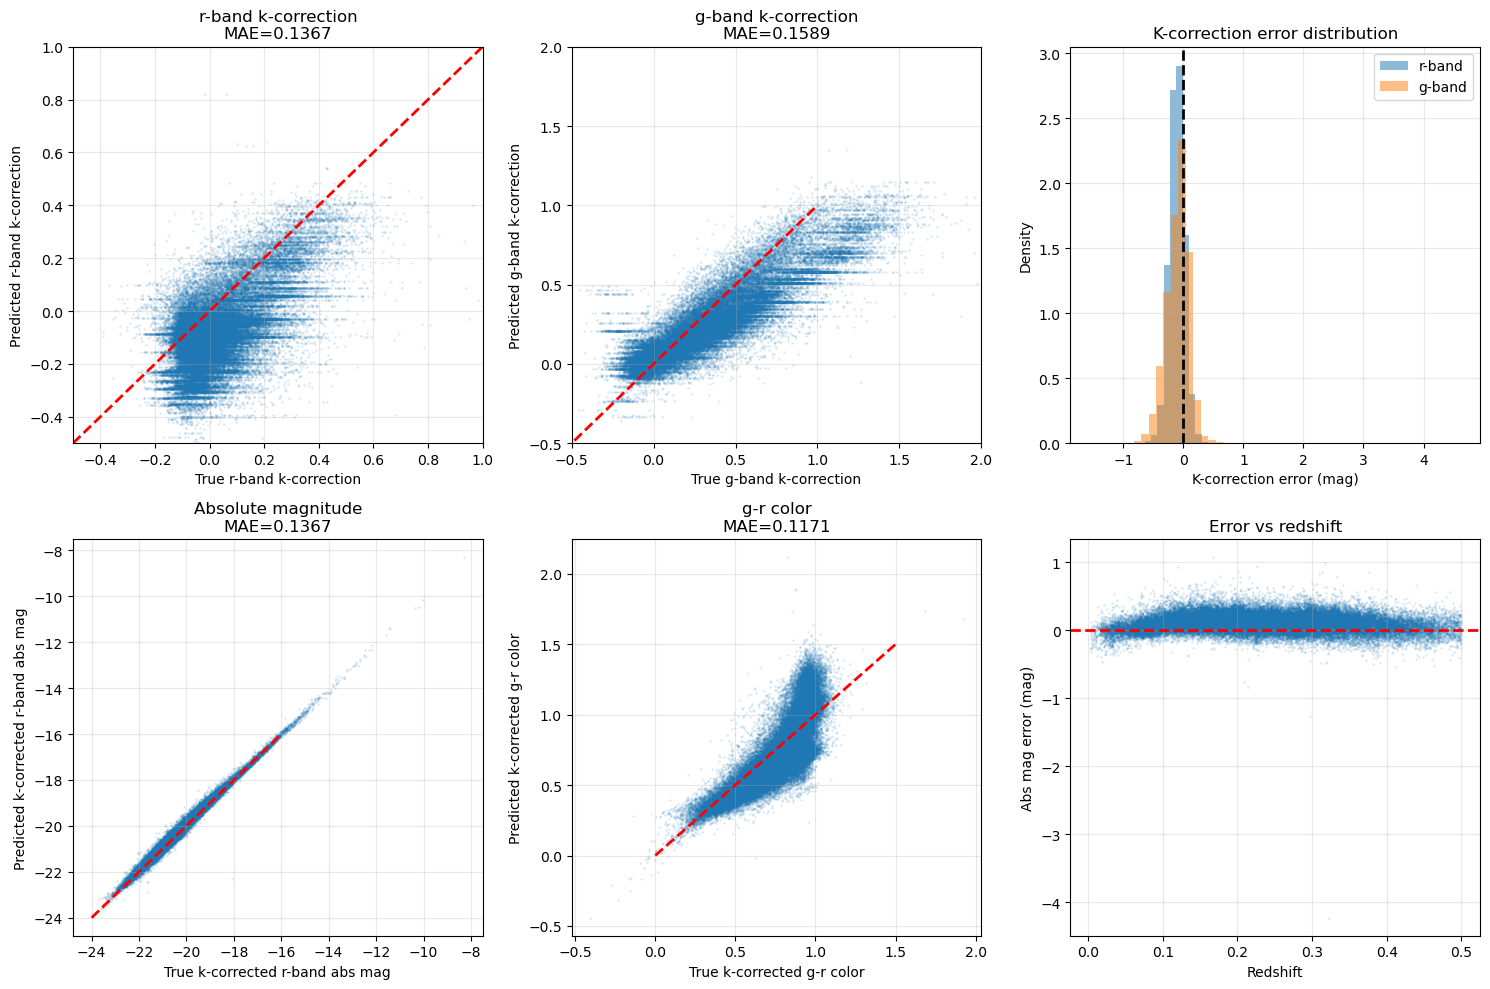

In [33]:
# Take a random subset of Y3 for validation (up to 100k)
n_validate = min(100000, len(df_y3))
validation_idx = np.random.choice(len(df_y3), size=n_validate, replace=False)
df_y3_subset = df_y3.iloc[validation_idx].copy()
print(f"Loaded {n_validate:,} Y3 galaxies for validation")

# Remove data points that were in Y1 (use TARGETID)
y1_targetids = set(df['TARGETID'].values)
not_in_y1 = ~df_y3_subset['TARGETID'].isin(y1_targetids)
df_y3_subset = df_y3_subset[not_in_y1].copy()
print(f"After removing Y1 galaxies: {len(df_y3_subset):,} Y3 galaxies remaining")

# Filter to galaxies with all required data
has_kcorr = ~np.isnan(df_y3_subset['ABSMAG01_SDSS_R']) & ~np.isnan(df_y3_subset['ABSMAG01_SDSS_G'])
has_mags = ~np.isnan(df_y3_subset['ABS_MAG_R']) & ~np.isnan(df_y3_subset['ABS_MAG_G'])
has_z = ~np.isnan(df_y3_subset['Z'])
valid_y3 = has_kcorr & has_mags & has_z

df_y3_valid = df_y3_subset[valid_y3].copy()
print(f"Number of Y3 galaxies with complete data: {len(df_y3_valid):,}")

# Load the saved lookup table
print(f"\nLoading lookup table from {BGS_Y3_KCORR_LOOKUP_FILE}...")
lookup = kcorrlookup()

# Query the lookup table for Y3 galaxies
z_y3 = df_y3_valid['Z'].to_numpy()
magr_y3 = df_y3_valid['ABS_MAG_R'].to_numpy()
magg_y3 = df_y3_valid['ABS_MAG_G'].to_numpy()
gmr_y3 = magg_y3 - magr_y3

# Get predicted k-corrections
pred_kcorr_r_y3, pred_kcorr_g_y3  = lookup.query(gmr_y3, z_y3, magr_y3)

# True k-corrections from Y3
true_kcorr_r_y3 = magr_y3 - df_y3_valid['ABSMAG01_SDSS_R'].to_numpy()
true_kcorr_g_y3 = magg_y3 - df_y3_valid['ABSMAG01_SDSS_G'].to_numpy()

# Calculate errors
kcorr_r_error = pred_kcorr_r_y3 - true_kcorr_r_y3
kcorr_g_error = pred_kcorr_g_y3 - true_kcorr_g_y3

# Calculate predicted k-corrected magnitudes
pred_abs_mag_r_kcorr = magr_y3 - pred_kcorr_r_y3
pred_abs_mag_g_kcorr = magg_y3 - pred_kcorr_g_y3
pred_gmr_kcorr = pred_abs_mag_g_kcorr - pred_abs_mag_r_kcorr

# True k-corrected magnitudes
true_abs_mag_r_kcorr = df_y3_valid['ABSMAG01_SDSS_R'].to_numpy()
true_abs_mag_g_kcorr = df_y3_valid['ABSMAG01_SDSS_G'].to_numpy()
true_gmr_kcorr = true_abs_mag_g_kcorr - true_abs_mag_r_kcorr

# Calculate magnitude errors
abs_mag_r_error = pred_abs_mag_r_kcorr - true_abs_mag_r_kcorr
gmr_error = pred_gmr_kcorr - true_gmr_kcorr

# Print validation statistics
print("\n" + "="*60)
print("VALIDATION RESULTS")
print("="*60)
print("\nK-correction errors:")
print(f"  r-band k-corr MAE: {np.mean(np.abs(kcorr_r_error)):.4f} mag")
print(f"  g-band k-corr MAE: {np.mean(np.abs(kcorr_g_error)):.4f} mag")
print(f"  r-band k-corr RMS: {np.sqrt(np.mean(kcorr_r_error**2)):.4f} mag")
print(f"  g-band k-corr RMS: {np.sqrt(np.mean(kcorr_g_error**2)):.4f} mag")

print("\nK-corrected magnitude errors:")
print(f"  r-band abs mag MAE: {np.mean(np.abs(abs_mag_r_error)):.4f} mag")
print(f"  g-r color MAE: {np.mean(np.abs(gmr_error)):.4f} mag")
print(f"  r-band abs mag RMS: {np.sqrt(np.mean(abs_mag_r_error**2)):.4f} mag")
print(f"  g-r color RMS: {np.sqrt(np.mean(gmr_error**2)):.4f} mag")


# Plot validation results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: K-correction comparison for r-band
ax = axes[0, 0]
ax.scatter(true_kcorr_r_y3, pred_kcorr_r_y3, alpha=0.1, s=1)
ax.plot([-1, 1], [-1, 1], 'r--', lw=2)
ax.set_xlim(-0.5, 1)
ax.set_ylim(-0.5, 1)
ax.set_xlabel('True r-band k-correction')
ax.set_ylabel('Predicted r-band k-correction')
ax.set_title(f'r-band k-correction\nMAE={np.mean(np.abs(kcorr_r_error)):.4f}')
ax.grid(True, alpha=0.3)

# Plot 2: K-correction comparison for g-band
ax = axes[0, 1]
ax.scatter(true_kcorr_g_y3, pred_kcorr_g_y3, alpha=0.1, s=1)
ax.plot([-1, 1], [-1, 1], 'r--', lw=2)
ax.set_xlim(-0.5, 2)
ax.set_ylim(-0.5, 2)
ax.set_xlabel('True g-band k-correction')
ax.set_ylabel('Predicted g-band k-correction')
ax.set_title(f'g-band k-correction\nMAE={np.mean(np.abs(kcorr_g_error)):.4f}')
ax.grid(True, alpha=0.3)

# Plot 3: K-correction error histogram
ax = axes[0, 2]
ax.hist(kcorr_r_error, bins=50, alpha=0.5, label='r-band', density=True)
ax.hist(kcorr_g_error, bins=50, alpha=0.5, label='g-band', density=True)
ax.axvline(0, color='k', linestyle='--', lw=2)
ax.set_xlabel('K-correction error (mag)')
ax.set_ylabel('Density')
ax.set_title('K-correction error distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Absolute magnitude comparison
ax = axes[1, 0]
ax.scatter(true_abs_mag_r_kcorr, pred_abs_mag_r_kcorr, alpha=0.1, s=1)
ax.plot([-24, -16], [-24, -16], 'r--', lw=2)
ax.set_xlabel('True k-corrected r-band abs mag')
ax.set_ylabel('Predicted k-corrected r-band abs mag')
ax.set_title(f'Absolute magnitude\nMAE={np.mean(np.abs(abs_mag_r_error)):.4f}')
ax.grid(True, alpha=0.3)

# Plot 5: g-r color comparison
ax = axes[1, 1]
ax.scatter(true_gmr_kcorr, pred_gmr_kcorr, alpha=0.1, s=1)
ax.plot([0, 1.5], [0, 1.5], 'r--', lw=2)
ax.set_xlabel('True k-corrected g-r color')
ax.set_ylabel('Predicted k-corrected g-r color')
ax.set_title(f'g-r color\nMAE={np.mean(np.abs(gmr_error)):.4f}')
ax.grid(True, alpha=0.3)

# Plot 6: Error vs redshift
ax = axes[1, 2]
ax.scatter(z_y3, abs_mag_r_error, alpha=0.1, s=1)
ax.axhline(0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Redshift')
ax.set_ylabel('Abs mag error (mag)')
ax.set_title('Error vs redshift')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()